In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import scienceplots
import shutup

from joblib import Parallel, delayed

from lib import data, spks_utils, fitlvm_utils, fit_models, eval_models, models, utils

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# pretty plots
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib widget
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# seed and suppress warnings :-)
fit_models.seed()
shutup.please()

In [118]:
trial_data

,itrial,rewarded_side,current_block_side,reward_volume,min_trials_per_block,trial_cue_frequency,reward_cue_frequency,trial_cue_duration,reward_cue_duration,punishment_cue_duration,...,task_start_time,block_performance,block_side,response_time,response,rewarded,punished,response_prev,rewarded_prev,is_mb
1,1,left,left,4.0,23,2000,9000,0.25,0.25,1,...,9.807368,0.000000,left,0.633595,1,1,0,1,1,0
2,2,left,left,4.0,23,2000,9000,0.25,0.25,1,...,14.656154,0.000000,left,0.643849,1,1,0,1,1,0
3,3,left,left,4.0,23,2000,9000,0.25,0.25,1,...,19.505086,0.000000,left,0.602787,1,1,0,1,1,0
4,4,left,left,4.0,23,2000,9000,0.25,0.25,1,...,24.322072,0.000000,left,0.583492,1,1,0,1,1,0
5,5,left,left,4.0,23,2000,9000,0.25,0.25,1,...,29.309079,NaN,left,0.573465,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,425,left,left,4.0,22,2000,9000,0.25,0.25,1,...,2042.284132,0.600000,left,0.659658,1,1,0,-1,0,0
426,426,left,left,4.0,22,2000,9000,0.25,0.25,1,...,2047.499630,0.600000,left,0.653384,1,1,0,1,1,0
427,427,left,left,4.0,22,2000,9000,0.25,0.25,1,...,2052.356944,0.666667,left,0.670308,1,1,0,1,1,0
428,428,left,left,4.0,22,2000,9000,0.25,0.25,1,...,2057.521776,0.733333,left,0.807888,1,1,0,1,1,0


In [ ]:
# # trial_data_r_all, trial_data_all, session_data_all, unit_spike_times_all, regions_all = data.load_data(thresh=1) # 1m 15s
# regions_all = np.array([[list(unit_spike_times_all[subj_idx][sess_idx].keys()) for sess_idx in range(len(data.session_ids[subj_idx]))] for subj_idx in range(len(data.subject_ids))])
# # trial_data_all_npz = utils.list2ndarr(trial_data_all)
# # np.savez("vars/trial_data_all_MM012_MM013_5sess.npz", trial_data_all_npz)
# # np.save("vars/session_data_all_MM012_MM013_5sess.npy", session_data_all)
# # np.save("vars/unit_spike_times_all_MM012_MM013_5sess.npy", unit_spike_times_all)
# np.save("vars/regions_all.npy", regions_all, allow_pickle=True)

In [3]:
trial_data_all = np.load("vars/trial_data_all_MM012_MM013_5sess.npz", allow_pickle=True)['arr_0']
session_data_all = np.load("vars/session_data_all_MM012_MM013_5sess.npy", allow_pickle=True)
unit_spike_times_all = np.load("vars/unit_spike_times_all_MM012_MM013_5sess.npy", allow_pickle=True)
regions_all = np.load("vars/regions_all.npy", allow_pickle=True)

## NB

In [4]:
subj_idx = 0; sess_idx = 3

unit_spike_times = unit_spike_times_all[subj_idx][sess_idx]
trial_data = trial_data_all[subj_idx][sess_idx]
session_data = session_data_all[subj_idx][sess_idx]
regions = regions_all[subj_idx][sess_idx]

In [102]:
0.65**2

0.42250000000000004

In [101]:
psths, _, _, _, _, _, mask = data.get_psths(unit_spike_times, trial_data, session_data, regions, 
                                tpre=0.5, tpost=0.5, binwidth_ms=25, alignment='choice', 
                            balance=True, reward_only=False, do_rem_zstd=True, shuffle=False, prev_filter=False)
trial_data = trial_data[mask]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_gd, train_dl, val_dl, test_dl, train_inds, val_inds, test_inds, Mtrain, Mtest, sample, num_trials, num_tv, num_units = fitlvm_utils.get_data_model(psths, trial_data, regions, norm=False, num_tents=2, task_vars=['response', 'rewarded', 'response_prev', 'rewarded_prev'])

0 291 96 16
originally 187 units
0.6512638316840904
good units 187
403 Trials, 187 Neurons


Step 0
Found 81 /186 units with stable low-dimensional structure at rank 1
Step 1: Baseline
Fitting baseline model...done
Step 2: Task Var
Fitting task variable model...done
Step 2a: Eval
as expected


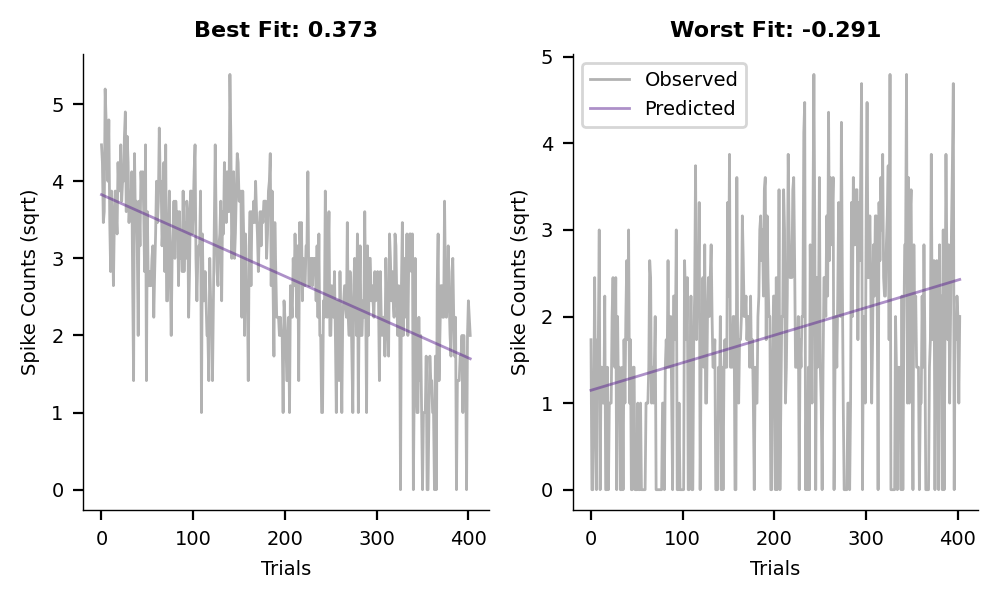

as expected


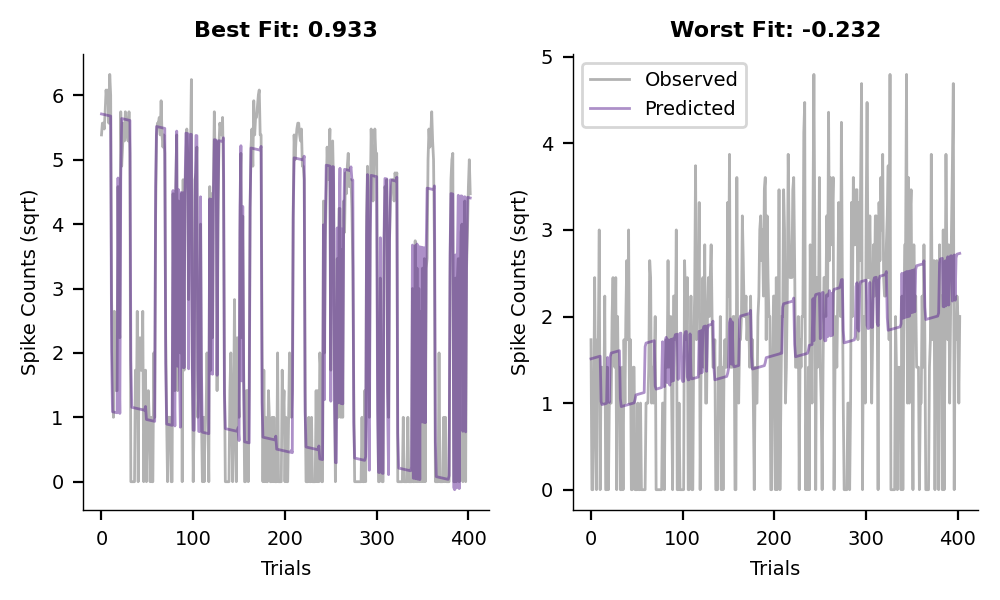

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


Step3a: Inclusion Criteria
Found 163 /186 units with significant task variable + drift model
183 185
Using 175 total units for modeling


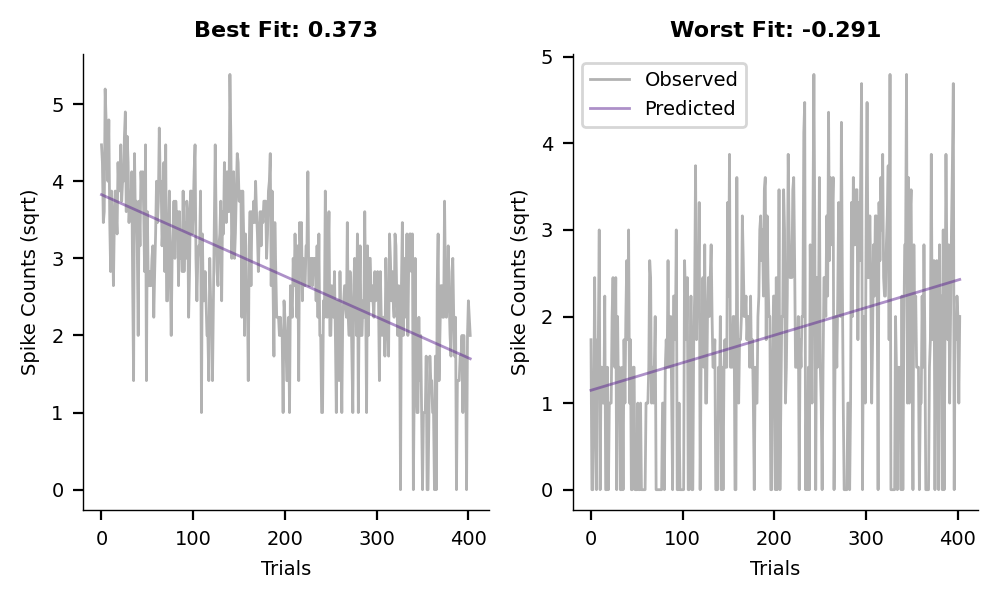

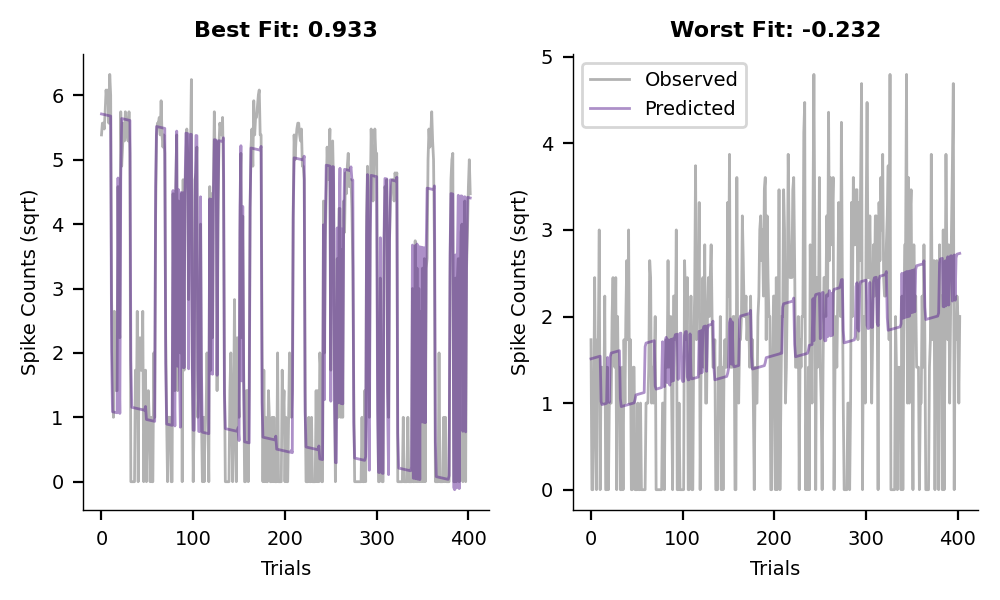

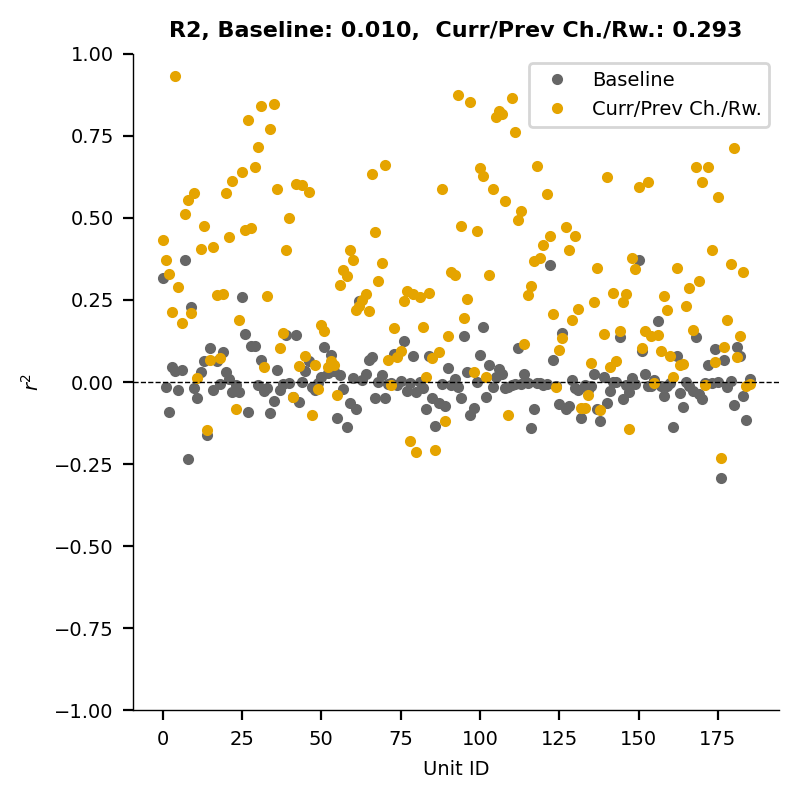

In [6]:
# MODELING
# Step 0: Check if dataset has stable low-dim structure at 4+ dims
print("Step 0")
cids_pca = fitlvm_utils.check_stable_lowd(data_gd, Mtrain, Mtest, num_units)

# Step 1: Fit baseline model
# > Baseline model: has no task vars, can capture slow drift in firing rate for each unit using b0-splines
print("Step 1: Baseline")
mod_baseline = fitlvm_utils.fit_baseline(train_dl, val_dl, num_tv, num_units, ntents=2)

# Step 2: Fit model with task vars and slow drift
# > Task vars & slow drift: Used to identify units driven by task vars
print("Step 2: Task Var")
mod_tv = fitlvm_utils.fit_tvs(train_dl, val_dl, num_tv, num_units, mod_baseline) 

# Step 2a: Evaluate and plot comparison for baseline and task variable models
print("Step 2a: Eval")
res_baseline        = fitlvm_utils.eval_model(mod_baseline, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp([], res_baseline, res_tv, label_a="Baseline", label_b="Curr/Prev Ch./Rw.", save=False)

# Step 3a: Get units that had significant performance increase with a task variable model
print("Step3a: Inclusion Criteria")
cids = fitlvm_utils.get_cids(cids_pca, res_tv)

In [97]:
# # Step 3b: Fit gain autoencoder
# # NOTE: fitting done by first fixing drift/tv, first pass fit latent weights; then refit drift/tv and latents independently
print("Step 3b: Gain AE")
mod_ae_gain = fitlvm_utils.fit_ae_gain(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=3) 

# Step 3c: Fit offset autoencoder
print("Step 3c: Offset AE")
mod_ae_offset = fitlvm_utils.fit_ae_offset(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=3)

# # Step 3d: Fit affine autoencoder
print("Step 3d: Affine AE")
mod_ae_affine, r2 = fitlvm_utils.fit_ae_affine(train_dl, val_dl, test_dl, mod_tv, mod_ae_gain, mod_ae_offset, cids, num_tv, num_units, data_gd, device, num_latents=3)


Step 3b: Gain AE
Fitting gain autoencoder...Initial: -151.2966
Fit latents: -151.2966, 0.4397
0) fit task vars: 0.4397, 0.3945
0) fit latents: 0.3945, 0.4192
1) fit task vars: 0.4192, 0.4152
breaking because tolerance was hit
Done
Step 3c: Offset AE
Fitting offset autoencoder...
Initial: -12.8339
Fit latents: -12.8339, 0.4433
0) fit task vars: 0.4433, 0.4117
0) fit latents: 0.4117, 0.4204
1) fit task vars: 0.4204, 0.4152
breaking because tolerance was hit
Done
Step 3d: Affine AE
Fitting affine autoencoder...Initial: -2.0885
Fit latents: -2.0885, 0.4855
0) fit task vars: 0.4855, 0.4564
0) fit latents: 0.4564, 0.4696
1) fit task vars: 0.4696, 0.4616
breaking because tolerance was hit
Done
175
Autoencoder iter 0, val r2: 0.4616
as expected
checkpoint 1
checkpoint 2
confirming model r2 = 0.4616
175


In [117]:
dfs.shape

torch.Size([403, 175])

Step 3e: Eval
as expected
checkpoint 1
checkpoint 2


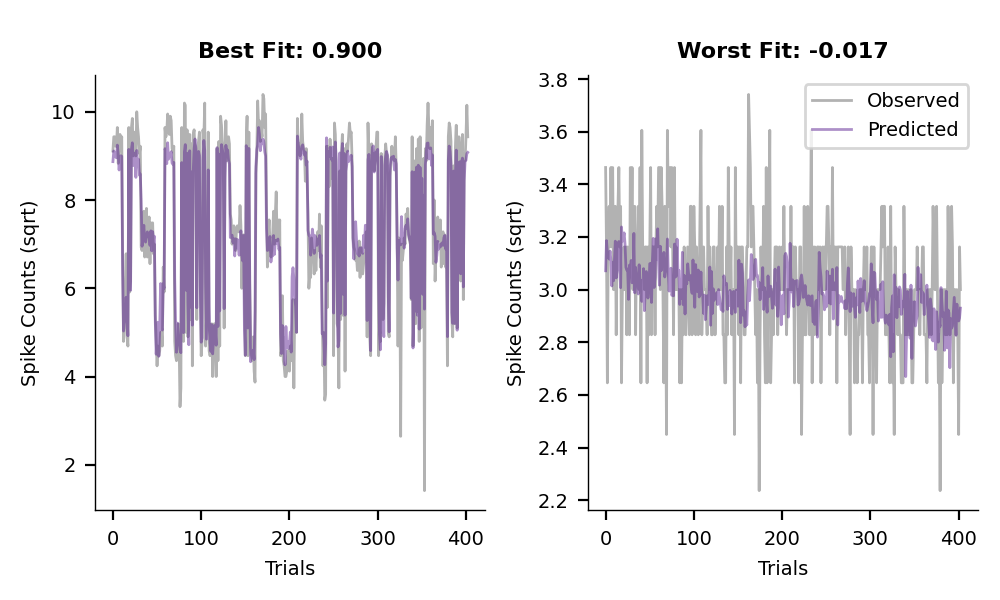

as expected


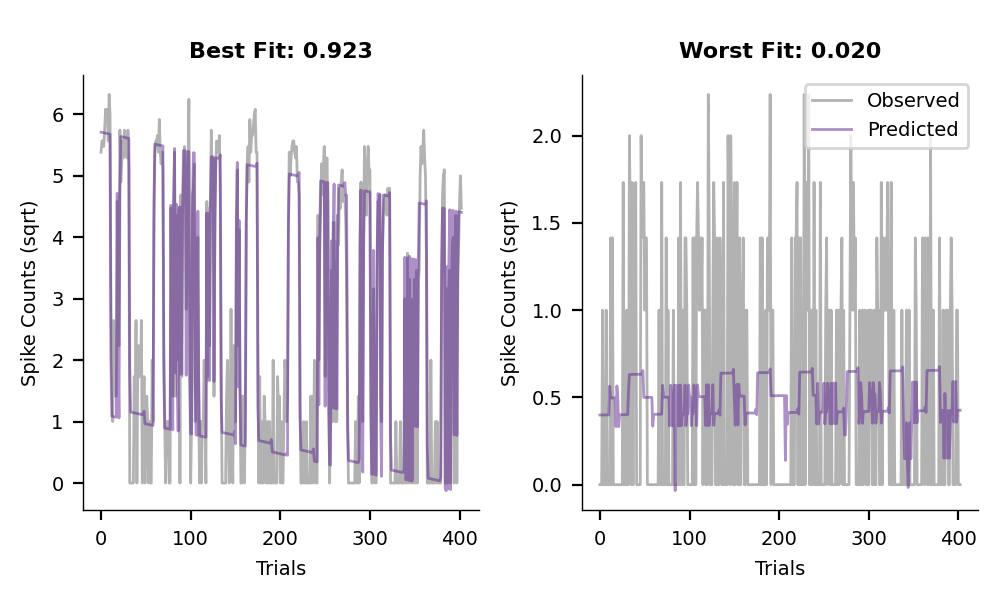

[<Figure size 800x800 with 1 Axes>]

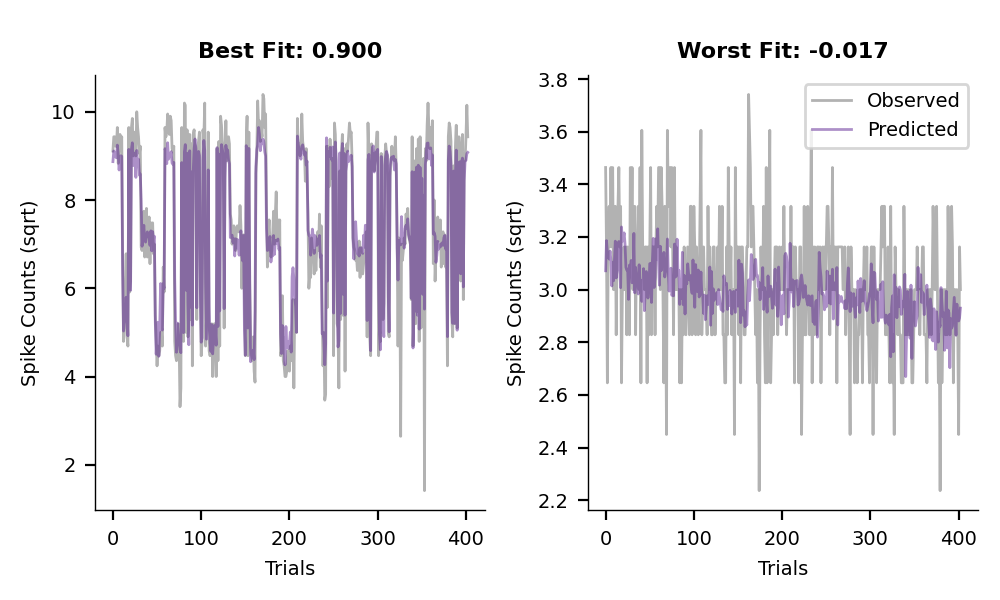

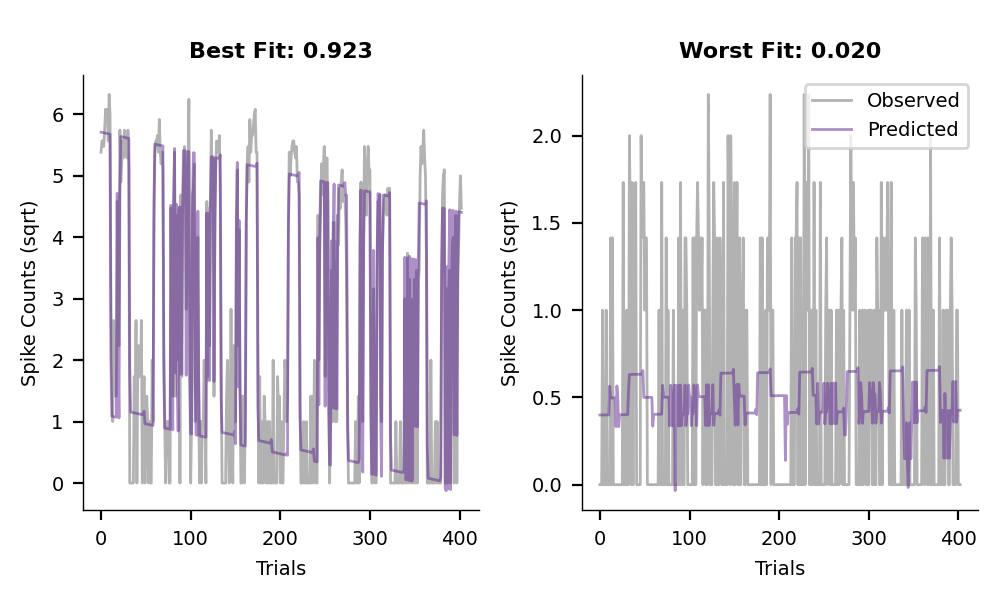

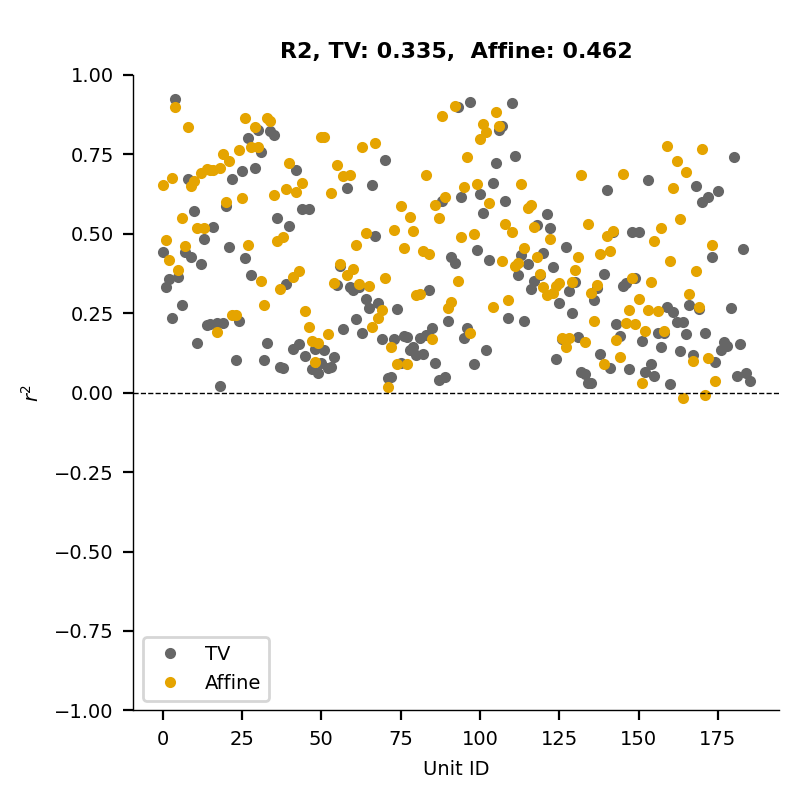

In [98]:
print("Step 3e: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp([], res_tv, res_affineae, label_a="TV", label_b="Affine", save=False)

In [99]:
# Step 3e: Convert ae to lvm
# NOTE: the difference between affine and affineae is that affineae (step 3) is fit with weights initialized by an autoencoder
print("Step 3e: AE to LVM")
mod_ae_offset, mod_ae_gain, mod_ae_affine_lvm = fitlvm_utils.ae2lvm(train_dl, val_dl, mod_ae_offset, mod_ae_gain, mod_ae_affine, cids, num_tv, num_units, data_gd, num_latents=3)

# Step 4: Fit affine model
# print("Step 4: Fit Affine")
# mod_affine = fitlvm_utils.fit_affine(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=3)


Step 3e: AE to LVM
Initial: 0.4152
Initial: 0.4152
Fit latents: 0.4152, 0.4181
0, BOO
0) fit stim: 0.4152, 0.4147
0) fit latents: 0.4147, 0.4175
1, BOO
1) fit stim: 0.4175, 0.4158
breaking because tolerance was hit
Fit run 0.000,0.010: 0.4175, train loss = 0.5226
Initial: 0.4152
Initial: 0.4152
Fit latents: 0.4152, 0.4199
0, BOO
0) fit stim: 0.4152, 0.4166
0) fit latents: 0.4166, 0.4205
1, BOO
1) fit stim: 0.4205, 0.4182
breaking because tolerance was hit
Fit run 0.010,0.000: 0.4205, train loss = 0.5384
Initial: 0.4616
Initial: 0.4616
Fit latents: 0.4616, 0.4715
0, BOO
0) fit stim: 0.4616, 0.4569
0) fit latents: 0.4569, 0.4717
1, BOO
1) fit stim: 0.4717, 0.4678
breaking because tolerance was hit
Fit run 0.010,0.010: 0.4717, train loss = 0.4803


In [49]:
sample = test_dl.dataset[:]
robs_ = sample['robs'].detach().cpu()
rhat_ = mod_ae_affine(sample).detach().cpu()
rhat_lvm_ = mod_ae_affine_lvm(sample).detach().cpu()

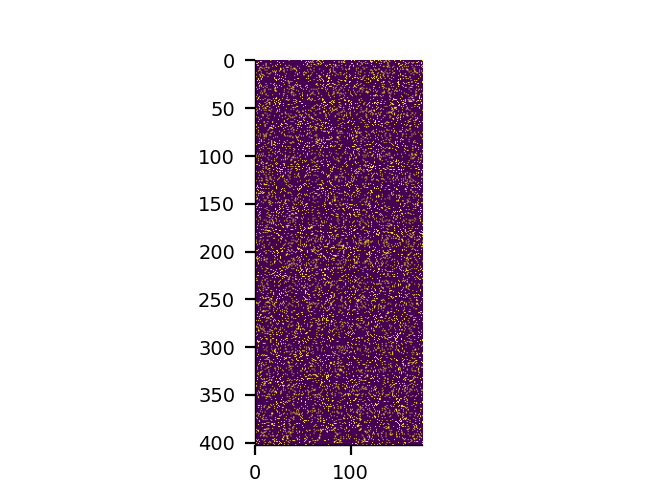

tensor(0.1233)


In [82]:
y = robs_[:,mod_ae_affine_lvm.cids]
yhat = rhat_lvm_
dfs = sample['dfs'][:,mod_ae_affine_lvm.cids].detach().cpu()

plt.figure(); plt.imshow(dfs); plt.show()
print(torch.mean(dfs))

In [89]:
if dfs is None:
    dfs = torch.ones(y.shape, device=y.device)
ybar = (y * dfs).sum(dim=0) / dfs.sum(dim=0) # the average y value
resids = y - yhat # the difference between observed and predicted
residnull = y - ybar # the difference between observed and observed avg
sstot = torch.sum( residnull**2*dfs, dim=0) # denom
ssres = torch.sum( resids**2*dfs, dim=0) # num
r2 = 1 - ssres/sstot

In [96]:
max(r2)

tensor(0.9224)

In [93]:
if dfs is None:
    dfs = torch.ones(y.shape, device=y.device)
ybar = (y).sum(dim=0) / dfs.shape[0] # the average y value
resids = y - yhat # the difference between observed and predicted
residnull = y - ybar # the difference between observed and observed avg
sstot = torch.sum( residnull**2, dim=0) # denom
ssres = torch.sum( resids**2, dim=0) # num
r2 = 1 - ssres/sstot

In [54]:
ssres[81]

tensor(25.4602)

In [95]:
r2[81]

tensor(0.2987)

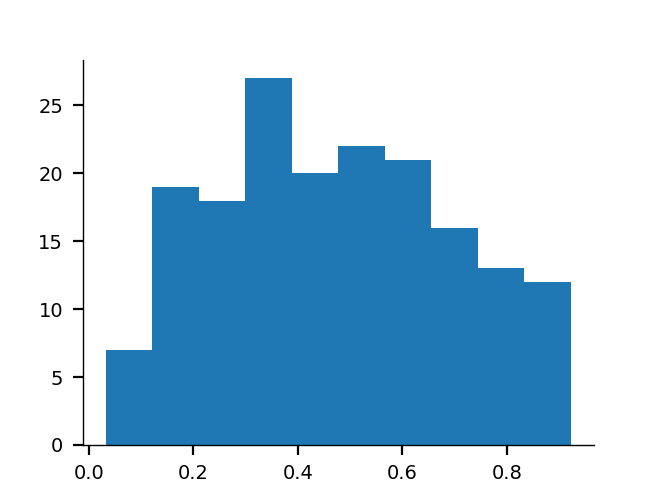

In [94]:
plt.figure(); plt.hist(r2); plt.show()

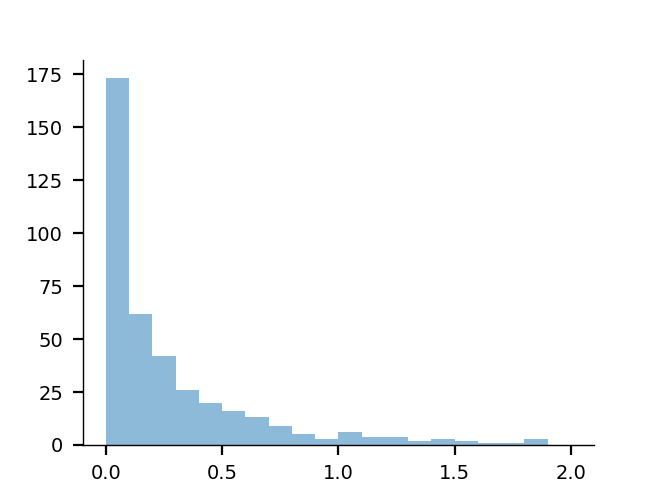

In [84]:
plt.figure()
plt.hist(resids[:,81]**2, bins=np.linspace(0,2,21), alpha=0.5)
plt.hist(residnull[:,81]**2, bins=np.linspace(0,2,21), alpha=0.5)
plt.show()

In [ ]:
49/400

In [113]:
torch.sum(dfs[:,9])

tensor(51.)

In [73]:
robs_.shape

torch.Size([403, 186])

In [72]:
mu.shape

torch.Size([186])

In [78]:
dfs.shape

torch.Size([403, 186])

C:\Users\danci\AppData\Local\Temp\ipykernel_25508\3464630687.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  adiff = np.abs(robs_ - mu)


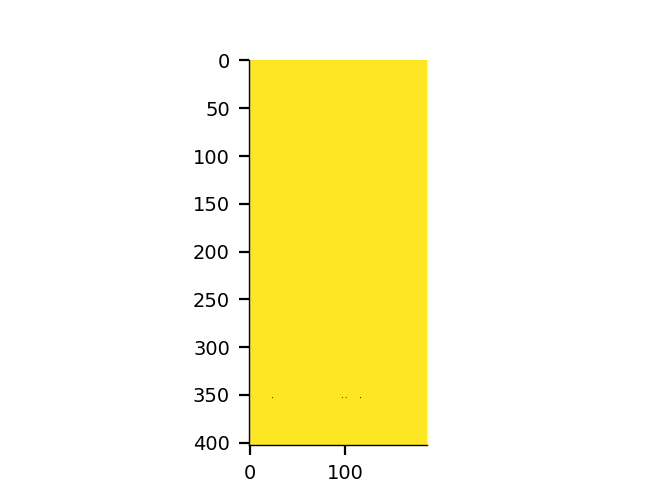

In [80]:
mu = torch.mean(robs_, axis=0)
adiff = np.abs(robs_ - mu)
mad = np.median(adiff)
dfs = (adiff / mad) < 8
plt.figure()
plt.imshow(dfs)
plt.show()

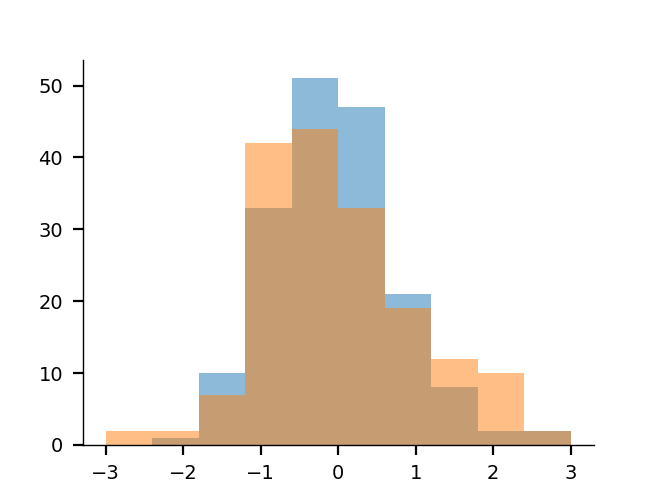

In [45]:
plt.figure()
plt.hist(resids[151], bins=np.linspace(-3,3,11), alpha=0.5)
plt.hist(residnull[151], bins=np.linspace(-3,3,11), alpha=0.5)
plt.show()

Step 2a: Eval
as expected
checkpoint 1
checkpoint 2


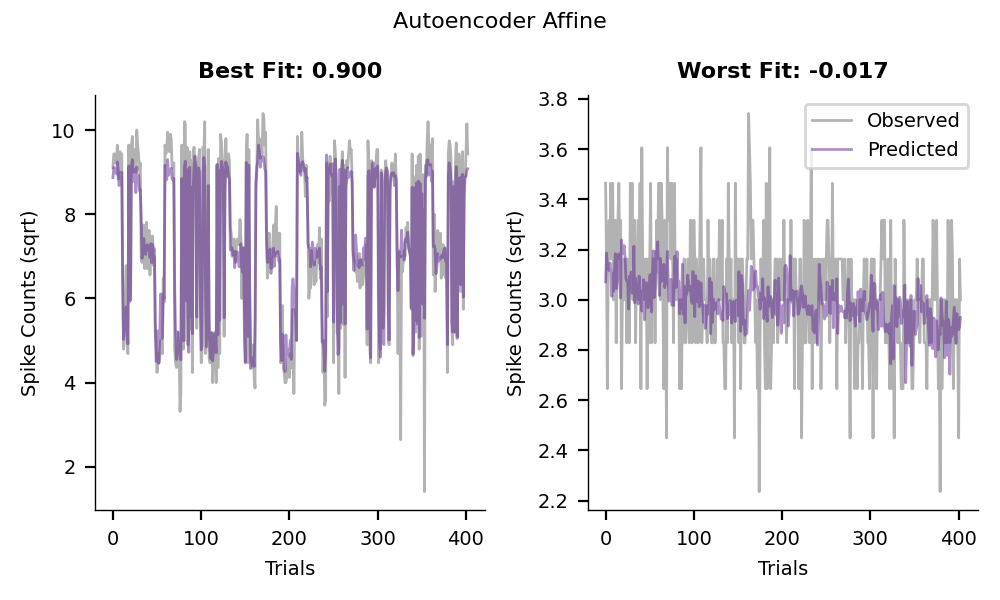

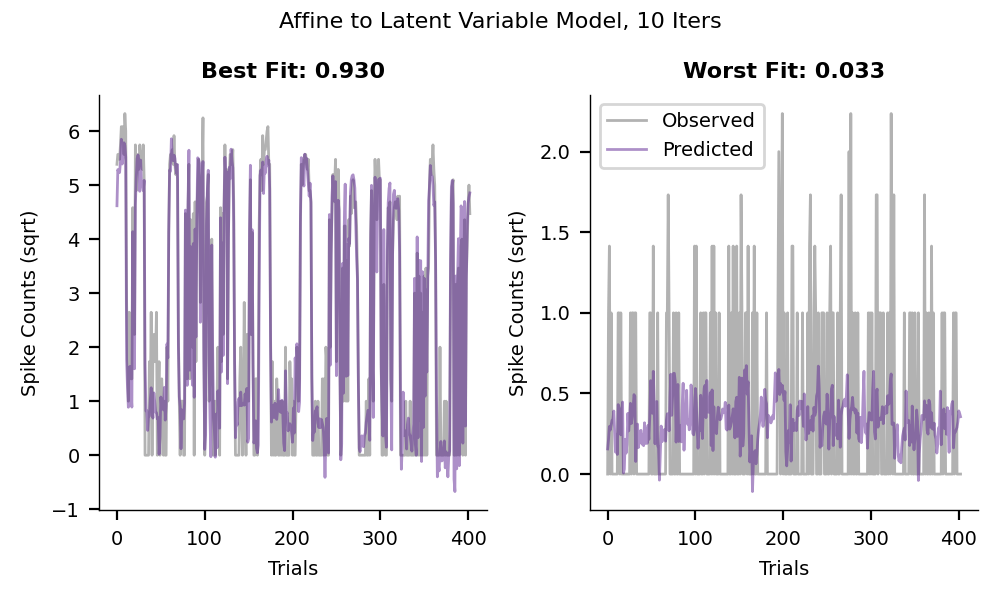

[<Figure size 800x800 with 1 Axes>]

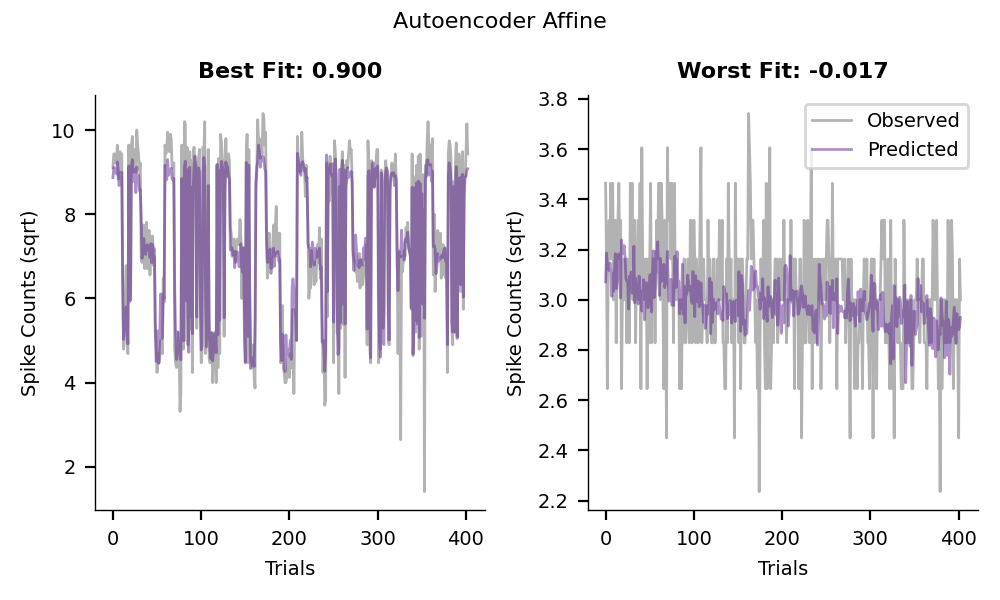

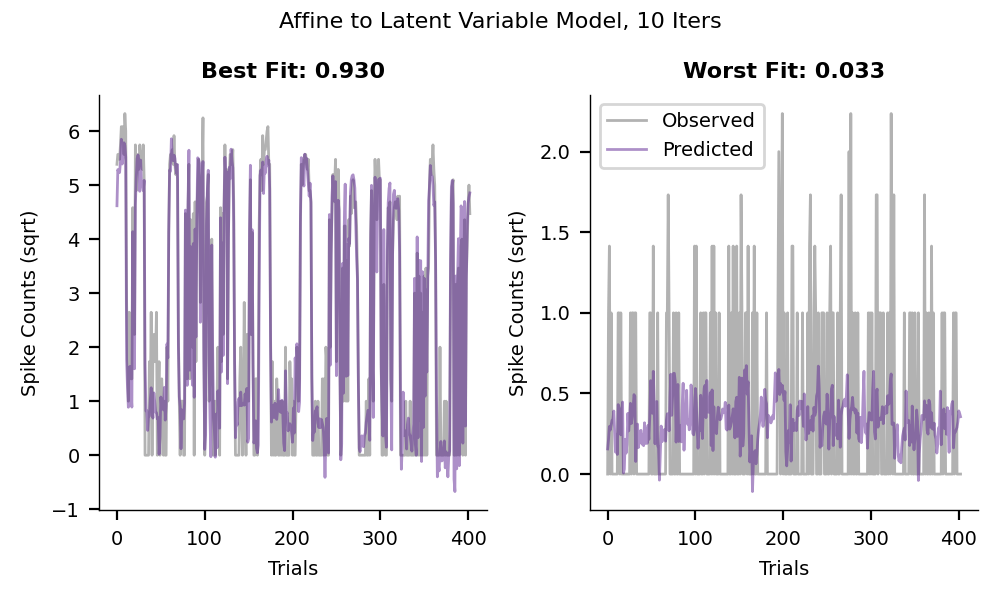

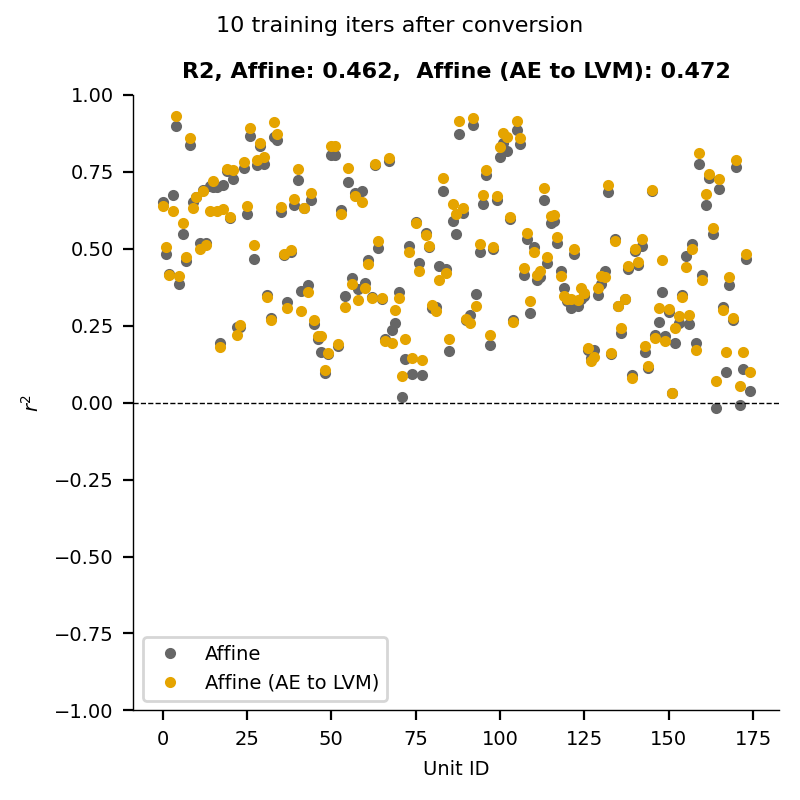

In [100]:
print("Step 2a: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, model="Autoencoder Affine", do_plot=True, save=False)
res_affineaelvm     = fitlvm_utils.eval_model(mod_ae_affine_lvm, data_gd, test_dl.dataset, model="Affine to Latent Variable Model, 10 Iters", do_plot=True, save=False)
fitlvm_utils.plot_r2_comp([], res_affineae, res_affineaelvm, label_a="Affine", label_b="Affine (AE to LVM)", title="10 training iters after conversion", save=False)

In [ ]:
# Step 5a: Fit gain only
# print("Step 5a: Fit gain only")
# mod_gain = fitlvm_utils.fit_gain(mod_ae_gain, mod_affine, train_dl, val_dl, cids, num_tv, num_units, data_gd, ntents=2, num_latents=3)

# # Step 5b: Fit offset only
# print("Step 5b: Fit offset only")
# mod_offset = fitlvm_utils.fit_offset(train_dl, val_dl, mod_ae_affine, mod_affine, cids, num_tv, num_units, data_gd, num_latents=3)

In [ ]:
# EVALUATION
print("Evaluating...")# EVALUATION
das_sess = fitlvm_utils.get_das(trial_data, regions, sample, train_inds, val_inds, test_inds, train_dl, test_dl, mod_baseline, mod_tv, mod_ae_offset, mod_ae_gain, mod_ae_affine, cids, data_gd, do_save=False, do_plot=True)

Evaluating...


NameError: name 'mod_ae_affine_lvm' is not defined

In [ ]:
fitlvm_utils.plot_summary(das_sess, subj_idx=subj_idx, sess_idx=sess_idx)

In [ ]:
def foo(das, ax0, ax1, num_latents, is_mult=True, abort=True):
    markers = ['v', '^', 'x', '*']
    colors = ["#140C6A", "#7166E9", "#845910", "#F7E164"]

    cids = das['affine']['model'].cids
    coupling = das['affine']['model'].readout_gain.weight.data[:].T if is_mult else das['affine']['model'].readout_offset.weight.data[:].T

    regs = das['data']['regions']
    reg_keys = das['data']['reg_keys'][cids]
    
    
    if abort and all([all(coupling[np.where(reg_keys==i)[0],ax0] == coupling[np.where(reg_keys==i)[0],ax1]) for i in reg_keys]):
        print(f"Latent {ax0+1} and Latent {ax1+1} are equal, aborting")
        return

    fig, ax = plt.subplots(figsize=(3,3))

    for i, reg in enumerate(regs):
        idxs = np.where(reg_keys==i)[0]
        coupling_reg = coupling[idxs]
        ax.plot(coupling_reg[:,ax0], coupling_reg[:,ax1], markers[i], color=colors[i], label=reg)
        #ax.axhline(torch.mean(coupling_reg), color=colors[i], linewidth=0.3, linestyle='--')

    ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
    ax.set_xlabel(f'Latent {ax0+1}'); ax.set_ylabel(f"Latent {ax1+1}")
    fig.suptitle(f"Total # Latents: {num_latents}")
    
    ax.set_ylim([-0.5,0.5])
    ax.set_xlim([-0.5,0.5])

    ax.legend()
    fig.tight_layout()
    fig.show()
    
def bah(das, num_latents):
    for ax in range(num_latents):
        plt.plot(das['affineae']['model'].offset_mu.get_weights()[:,ax], alpha=0.5, label=f"Latent {ax+1}")
    plt.title(f"Total # Latents: {num_latents}")
    plt.legend()

In [ ]:
bah(das_sess, num_latents=3)

In [ ]:
for ax0 in range(3):
    for ax1 in range(3):
        if ax0 < ax1:
            foo(das_sess, ax0=ax0, ax1=ax1, num_latents=3)

## Grid Search

In [ ]:
# SERIAL
out = [fit_models.fit_sess(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=latent_idx) for latent_idx in range(1,8+1)]
das = [out[latent_idx][0] for latent_idx in range(8)]

In [ ]:
# PARALLEL
def fit_sess_latents_gs(subj_idx, sess_idx):
    return Parallel(n_jobs=-1, backend='loky')(delayed(fit_models.fit_sess)(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=num_latents) for num_latents in range(1,8+1))
out = fit_sess_latents_gs(subj_idx=subj_idx, sess_idx=sess_idx) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_03_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=2) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_02_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=1) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_01_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=0) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_00_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=4) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_04_latents.npy', das)

In [ ]:
from lib import eval_models

In [ ]:
eval_models.plot_r2_laatents(das, subj_idx=0, sess_idx=3, is_msess=False)

In [ ]:
eval_models.plot_r2_latents(das, subj_idx=0, sess_idx=3, is_msess=False, ae=False)

In [ ]:
def bah(das, num_latents, ae=True, mult=True):
    plt.figure()
    model = das['affineae'] if ae else das['affine']
    weights = model['model'].gain_mu.get_weights() if mult else model['model'].offset_mu.get_weights() 
    for ax in range(num_latents):
        plt.plot(weights[:,ax], alpha=0.5, label=f"Latent {ax+1}")
    plt.title(f"Total # Latents: {num_latents}")
    plt.legend()

In [ ]:
for num_latents in range(1, 8+1): 
    bah(das[num_latents-1], num_latents=num_latents, ae=False)
     